In [48]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.datasets.images import ImageDataset
from torchlake.common.models import ImageNetNormalization, VGGFeatureExtractor
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import load_image, save_img_array
from torchlake.common.utils.plot import plot_grids
from torchlake.style_transfer.controller.trainer_fast_style_transfer import \
    FastStyleTransferTrainer
from torchlake.style_transfer.models.fast_style_transfer import \
    FastStyleTransfer
from torchlake.style_transfer.models.neural_style_transfer.loss import \
    NeuralStyleTransferLoss
from torchlake.common.utils.numerical import imagenet_denormalization

# setting

In [49]:
artifacts_path = Path('../../artifacts/fast-style-transfer')
artifacts_path.mkdir(exist_ok=True)

data_path = Path('../../data/VOCdevkit/**/JPEGImages/*.jpg')
content_path = Path('../../data/contents')
style_path = Path('../../data/styles')

In [50]:
DEVICE = torch.device('cuda:0')

In [51]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [52]:
transform_content = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.ToTensor(),
])

In [53]:
transform_style = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.ToTensor(),
])

# dataset

In [54]:
dataset = ImageDataset(data_path.as_posix(), transform_content)
data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [55]:
len(dataset)

27088

In [56]:
style = transform_style(load_image(style_path.joinpath("sketch.jpg"))).to(DEVICE)

# model

In [57]:
feature_extractor = VGGFeatureExtractor('vgg16', 'relu', trainable=False).to(DEVICE)

In [58]:
model = FastStyleTransfer(input_channel=3).to(DEVICE)

In [59]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
FastStyleTransfer                             --
├─Sequential: 1-1                             --
│    └─ImageNetNormalization: 2-1             --
│    └─ConvBlock: 2-2                         --
│    │    └─ReflectionPad2d: 3-1              --
│    │    └─Conv2d: 3-2                       7,808
│    │    └─InstanceNorm2d: 3-3               64
│    └─ConvBlock: 2-3                         --
│    │    └─ReflectionPad2d: 3-4              --
│    │    └─Conv2d: 3-5                       18,496
│    │    └─InstanceNorm2d: 3-6               128
│    └─ConvBlock: 2-4                         --
│    │    └─ReflectionPad2d: 3-7              --
│    │    └─Conv2d: 3-8                       73,856
│    │    └─InstanceNorm2d: 3-9               256
├─Sequential: 1-2                             --
│    └─ResidualBlock: 2-5                     --
│    │    └─ConvBlock: 3-10                   147,840
│    │    └─ConvBlock: 3-11                   

# training

In [60]:
EPOCH = 3
CONTENT_WEIGHT = 1e1
STYLE_WEIGHT = 5e5

In [14]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=3)
recorder.increment_data_size(len(dataset))

In [15]:
criterion = NeuralStyleTransferLoss(
    content_layer_idx=1,
    content_weight=CONTENT_WEIGHT,
    style_weight=STYLE_WEIGHT,
    return_all_loss=True,
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
trainer = FastStyleTransferTrainer(EPOCH, DEVICE)

In [17]:
CONTENT_LAYER_NAMES = ['2_1']
STYLE_LAYER_NAMES = ['1_1','2_1','3_1','4_1']

In [18]:
with torch.no_grad():
    style_features = feature_extractor(style.unsqueeze(0).repeat(BATCH_SIZE, 1, 1, 1), STYLE_LAYER_NAMES)

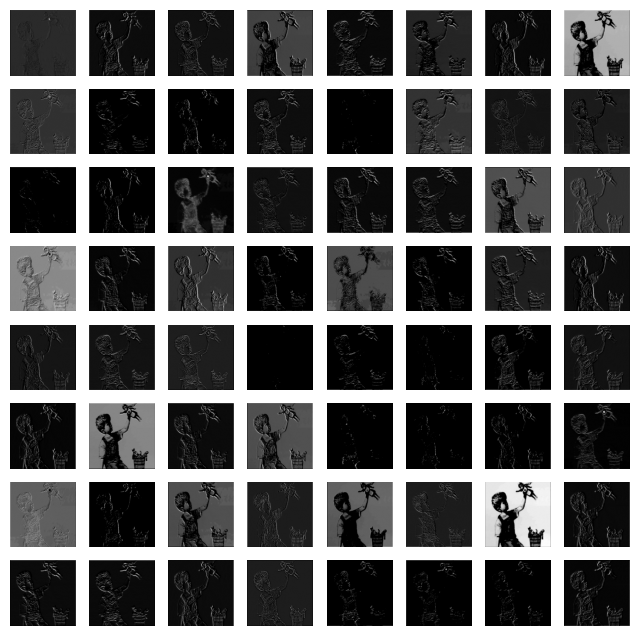

In [19]:
plot_grids(
    style_features[0][0].cpu(),
    num_row=8,
    num_col=8, 
    cmap='gray',
)

In [20]:
training_loss = trainer.run(
    data_loader,
    model,
    optimizer,
    criterion,
    recorder=recorder,
    style_features=style_features,
    feature_extractor=feature_extractor,
    content_layer_names=CONTENT_LAYER_NAMES,
    style_layer_names=STYLE_LAYER_NAMES,
)

Enable AMP: False
Training...


  0%|          | 0/1693 [00:00<?, ?it/s]

100%|██████████| 1693/1693 [08:15<00:00,  3.41it/s]


------------------------------------
Epoch 1
------------------------------------
8.378100087075143 (0%)
0.19076938656083367 (0%)
1.294081253865973e-05 (0%)


100%|██████████| 1693/1693 [11:23<00:00,  2.48it/s]


------------------------------------
Epoch 2
------------------------------------
3.6632645431525317 (-56%)
0.18174866272265305 (-5%)
3.691555827840367e-06 (-71%)


100%|██████████| 1693/1693 [12:15<00:00,  2.30it/s]

------------------------------------
Epoch 3
------------------------------------
2.7899623304447028 (-24%)
0.17428832633637553 (-4%)
2.0941581302702486e-06 (-43%)


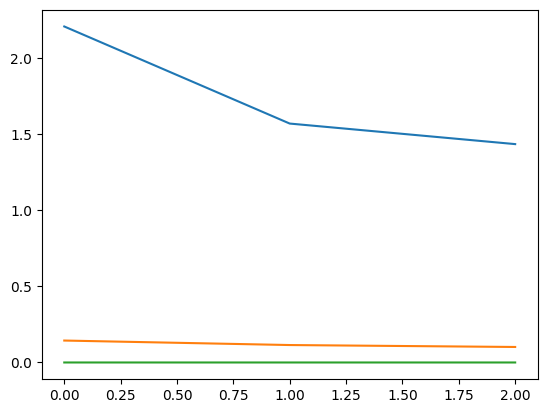

In [23]:
plt.plot(torch.Tensor(recorder.training_losses).T)

In [ ]:
wm = WeightManager(artifacts_path.joinpath('sketch.{content_weight:.0e}.{style_weight:.0e}.pth').as_posix())

In [15]:
model_path = wm.get_filename(content_weight=CONTENT_WEIGHT, style_weight=STYLE_WEIGHT)
model_path

WindowsPath('../../artifacts/fast-style-transfer/sketch.1e+01.5e+05.2.pth')

In [26]:
wm.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\fast-style-transfer\sketch.1e+01.5e+05.3.pth, model size is 6.43MiB


In [16]:
wm.load_weight(model_path, model)

# visualize

In [17]:
content_img = load_image(content_path / 'white-man.jpg', is_tensor=True)
style_img = load_image(style_path /'sketch.jpg', is_numpy=True)

In [21]:
model.eval()
with torch.no_grad():
    x = content_img.unsqueeze(0).to(DEVICE)
    output = model(x).cpu()
    output = imagenet_denormalization(output)
    output = img_tensor_to_np(output)

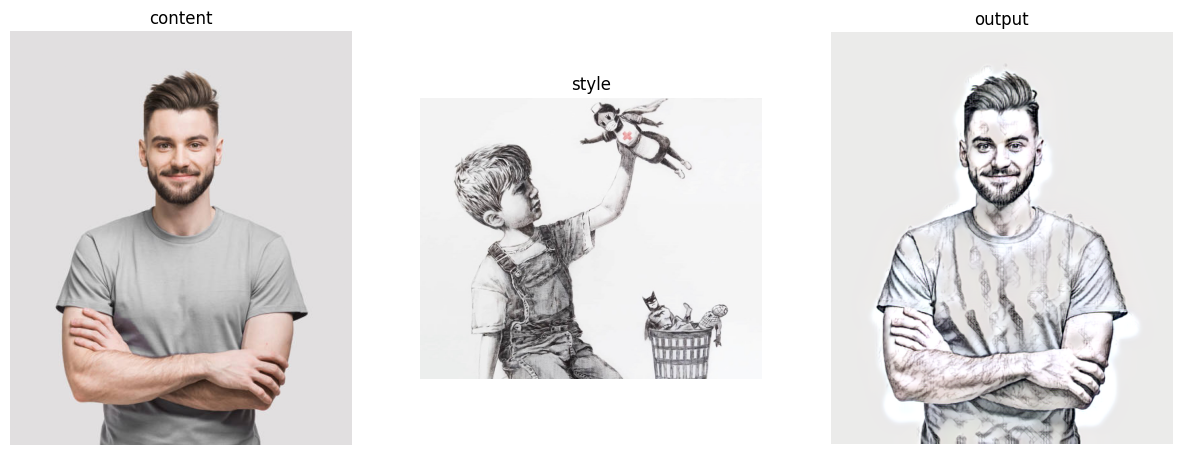

In [22]:
plot_grids(
    [img_tensor_to_np(content_img), style_img, output.clip(0, 1)],
    ['content', 'style', 'output'],
    num_row=1,
    num_col=3,
    figsize=(15, 10),
)

In [28]:
save_img_array(output[:,:,::-1], artifacts_path.joinpath('output.jpg').as_posix())

# video

In [64]:
wm = WeightManager(artifacts_path.joinpath('sketch.{content_weight:.0e}.{style_weight:.0e}.pth').as_posix())

In [65]:
model_path = wm.get_filename(content_weight=CONTENT_WEIGHT, style_weight=STYLE_WEIGHT)
model_path

WindowsPath('../../artifacts/fast-style-transfer/sketch.1e+01.5e+05.pth')

In [66]:
wm.load_weight(model_path, model)

In [67]:
from torchlake.common.helpers.video import VideoReader, VideoWriter

In [74]:
vid_reader = VideoReader(artifacts_path.joinpath("cat.mp4").as_posix())

In [75]:
vid_writer = VideoWriter(artifacts_path.joinpath("output.avi").as_posix(), "XVID", vid_reader.fps, vid_reader.shape[::-1])

In [ ]:
# because fps is 25, so i chose 5, a factor of 25, for less loading to process 720P clip
# and batch inference does not help much
VID_BATCH_SIZE = 5

In [ ]:
from torchlake.common.utils.convert import img_tensor_to_np

def transformed_generator():
    frame_h, frame_w = vid_reader.shape
    
    batch = []
    for _ in range(len(vid_reader)):
        ret, frame = vid_reader.read()
        if not ret:
            break
        
        # C, H, W
        frame = cv2.resize(frame, (frame_w // 2, frame_h))
        frame = frame.astype(np.float32)
        frame /= 255
        
        batch.append(frame)
        
        if len(batch) == VID_BATCH_SIZE:
            frames = np.stack(batch)
            
            model.eval()
            with torch.no_grad():
                output = torch.from_numpy(frames).permute(0, 3, 1, 2).to(DEVICE)
                output = model(output).cpu()
                output = imagenet_denormalization(output)
                output = img_tensor_to_np(output).clip(0, 1)

            # demonstrate by comparison
            compare_list = np.concatenate([frames, output], axis=2) * 255
            yield from compare_list.astype(np.uint8).clip(0, 255)
            
            batch.clear()
        
    return

In [78]:
vid_writer.run(transformed_generator())

2935it [03:13, 15.14it/s]


In [79]:
vid_reader.release()
vid_writer.release()